In [1]:
import rasterio as rio
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from scipy.interpolate import interp2d
import pandas as pd

from geogrid import GeogridOptical
from autoRIFT import autoRIFT
from osgeo import gdal, osr
import struct
import re
from datetime import date
import datetime
import xml.etree.ElementTree as ET
import urllib.request
import time
import subprocess
import cv2
import scipy.io as sio

from autorift_utilities import rio_write

gdal.AllRegister() # register all GDAL drivers

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce


## 1) Resample DEM and other autoRIFT/geogrid input rasters to the desired chip size

Recommended chip size is >= 16*pixel_resolution

#### Customizable parameters for geogrid:

    dhdx, dhdy:              x/y local surface slope maps (unitless)
    vx,vy:                   x/y reference velocity maps (in units of m/yr)
    srx, sry:                x/y velocity search range limit maps (in units of m/yr)
    csminx, csminy:          x/y chip size minimum maps (in units of m; constant ratio between x and y)
    csmaxx, csmaxy:          x/y chip size maximum maps (in units of m; constant ratio between x and y)
    ssm:                     stable surface mask (boolean)
    

In [2]:
######### ENTER CHIP SIZE, DEM INFO, AND REFERENCE VELOCITY INFO ########### 
CHIPSIZE_M = 100 # enter in desired grid size in meters (default is 32 pixels)

# enter in the path to your best DEM over the region
# dempath = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/DEMs_previous/'
# dempath = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/Variegated/'
dempath = '/Volumes/SURGE_DISK/LO/'
demname = 'LO_ArcticDEM_clipped.tif'

# path to the reference files for geogrid (vx, vy, ssm)
refvpath = '/Volumes/SURGE_DISK/LO/'
# vx_fname = 'vx_cropped.tif' # name of reference vx file
# vy_fname = 'vy_cropped.tif' # name of reference vy file
# refvpath = '/Volumes/SGlacier/' 
vx_fname = '' # name of reference vx file
vy_fname = '' # name of reference vy file
ssm_name = 'ssm.tif' # name of the stable surface mask (all off-ice areas)

sr_scaling = 16 # multiply by vx and vy to generate search range limits
############################################################################

In [3]:
# Read and grab info from your DEM
refdem = rio.open(dempath+demname) # open DEM using rasterio
elev = refdem.read(1) # read in the first and only band (elevations)

# grab the x and y grid values from the DEM:
dem_x = np.linspace(refdem.bounds.left, refdem.bounds.right, num=np.shape(elev)[1])
dem_y = np.linspace(refdem.bounds.top, refdem.bounds.bottom, num=np.shape(elev)[0])

# grab the resampled x and y grid values from the DEM
new_x = np.arange(refdem.bounds.left, refdem.bounds.right, CHIPSIZE_M)
new_y = np.arange(refdem.bounds.top, refdem.bounds.bottom, -CHIPSIZE_M)

In [4]:
# Resample the DEM to the input chip size
dem_outfile = demname[:-4]+'_'+str(CHIPSIZE_M)+'m.tif' # generate new filename

if not os.path.exists(dempath+dem_outfile): # if the resampled DEM does not exist already
    # Create thew new x and y grid values using DEM bounds and the chipsize
    dem_resamp = np.zeros((len(new_y), len(new_x))) # create an empty resampled DEM grid
    print(dem_resamp.shape)
    
    # Resample to your new DEM bounds
    f = interp2d(dem_x, dem_y, elev) # create DEM interpolation object
    dem_resamp = f(new_x,new_y) # resample the NIR data to the DSM coordinates
    dem_resamp = np.flipud(dem_resamp) # flip up down
    print("Resampled to new dimensions:",dem_resamp.shape)
    
    # Display the two DEMs as a visual check
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
    im1 = ax1.imshow(elev, cmap='Greys_r', vmin=0)
    ax1.set_title('Original DEM: '+str(refdem.transform[0])+' m') # original spatial resolution
    fig.colorbar(im1, ax=ax1,label='Elevation [m]')

    im2 = ax2.imshow(dem_resamp, cmap='Greys_r', vmin=0)
    ax2.set_title('Resampled DEM: '+str(CHIPSIZE_M)+' m') # new spatial resolution
    fig.colorbar(im2, ax=ax2,label='Elevation [m]')
    plt.show()
    
    # Save the resampled DEM to georeferenced tif file
    print("Save resampled DEM to", dempath+dem_outfile)
    rio_write(dempath+dem_outfile, dem_resamp, refdem, CHIPSIZE_M)
else:
    # load the empty grid
    dem_resamp = np.zeros((len(new_y), len(new_x))) # create an empty resampled DEM grid
    print(dem_outfile, ' already exists.')

LO_ArcticDEM_clipped_100m.tif  already exists.


In [5]:
# automatically set file names
dhdx_outfile = demname[:-4]+'_'+str(CHIPSIZE_M)+'m_dhdx.tif' # generate new filename
dhdy_outfile = demname[:-4]+'_'+str(CHIPSIZE_M)+'m_dhdy.tif' # generate new filename
ssm_outfile = 'ssm_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
vx_outfile = 'vx_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
vy_outfile = 'vy_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
srx_outfile = 'srx_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
sry_outfile = 'sry_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
csminx_fname = 'csminx_'+str(CHIPSIZE_M)+'m.tif'
csminy_fname = 'csminy_'+str(CHIPSIZE_M)+'m.tif'
csmaxx_fname = 'csmaxx_'+str(CHIPSIZE_M)+'m.tif'
csmaxy_fname = 'csmaxy_'+str(CHIPSIZE_M)+'m.tif'

In [6]:
def generate_geogrid_inputs(CHIPSIZE_M, dempath, demname, refvpath, vx_fname, vy_fname, sr_scaling):
    import rasterio as rio
    import os
    
    # GRAB DEM INFO
    refdem = rio.open(dempath+demname) # open DEM using rasterio
    elev = refdem.read(1) # read in the first and only band (elevations)

    # grab the x and y grid values from the DEM:
    dem_x = np.linspace(refdem.bounds.left, refdem.bounds.right, num=np.shape(elev)[1])
    dem_y = np.linspace(refdem.bounds.top, refdem.bounds.bottom, num=np.shape(elev)[0])

    # grab the resampled x and y grid values from the DEM
    new_x = np.arange(refdem.bounds.left, refdem.bounds.right, CHIPSIZE_M)
    new_y = np.arange(refdem.bounds.top, refdem.bounds.bottom, -CHIPSIZE_M)
    
    # RESAMPLE THE DEM
    dem_outfile = demname[:-4]+'_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
    if not os.path.exists(dempath+dem_outfile): # if the resampled DEM does not exist already
        # Create thew new x and y grid values using DEM bounds and the chipsize
        dem_resamp = np.zeros((len(new_y), len(new_x))) # create an empty resampled DEM grid
        print(dem_resamp.shape)

        # Resample to your new DEM bounds
        f = interp2d(dem_x, dem_y, elev) # create DEM interpolation object
        dem_resamp = f(new_x,new_y) # resample the NIR data to the DSM coordinates
        dem_resamp = np.flipud(dem_resamp) # flip up down
        print("Resampled to new dimensions:",dem_resamp.shape)

        # Display the two DEMs as a visual check
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
        im1 = ax1.imshow(elev, cmap='Greys_r', vmin=0)
        ax1.set_title('Original DEM: '+str(refdem.transform[0])+' m') # original spatial resolution
        fig.colorbar(im1, ax=ax1,label='Elevation [m]')

        im2 = ax2.imshow(dem_resamp, cmap='Greys_r', vmin=0)
        ax2.set_title('Resampled DEM: '+str(CHIPSIZE_M)+' m') # new spatial resolution
        fig.colorbar(im2, ax=ax2,label='Elevation [m]')
        plt.show()

        # Save the resampled DEM to georeferenced tif file
        print("Save resampled DEM to", dempath+dem_outfile)
        rio_write(dempath+dem_outfile, dem_resamp, refdem, CHIPSIZE_M)
    else:
        # load the existing resampled DEM
        dem_r = rio.open(dempath+dem_outfile) # open DEM using rasterio
        dem_resamp = dem_r.read(1) # read in the first and only band (elevations)
        print(dem_outfile, ' already exists.')
    
    # CREATE DHDX, DHDY
    dhdx_outfile = demname[:-4]+'_'+str(CHIPSIZE_M)+'m_dhdx.tif' # generate new filename
    dhdy_outfile = demname[:-4]+'_'+str(CHIPSIZE_M)+'m_dhdy.tif' # generate new filename
    if not os.path.exists(dempath+dhdx_outfile) or not os.path.exists(dempath+dhdy_outfile): # if either is missing
        # Produce dhdx and dhdy maps from resampled DEM
        dhdx = np.gradient(dem_resamp, axis=1)/CHIPSIZE_M
        dhdy = np.gradient(dem_resamp, axis=0)/CHIPSIZE_M

        # Filter out borders with high gradient values
        grad_thresh = 5
        dhdx[abs(dhdx) > grad_thresh] = 0; dhdy[abs(dhdy) > grad_thresh] = 0

        # absolute value of the max gradient values expected:
        dhmax = 1

        # Display the two DEMs as a visual check
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
        im1 = ax1.imshow(dhdx, cmap='Greys_r', vmin=-dhmax, vmax=dhmax)
        ax1.set_title('dhdx') # surface slope x
        fig.colorbar(im1, ax=ax1)

        im2 = ax2.imshow(dhdy, cmap='Greys_r', vmin=-dhmax, vmax=dhmax)
        ax2.set_title('dhdy') # surface slope y
        fig.colorbar(im2, ax=ax2)
        plt.show()

        # Save the gradient maps to tif files
        print("Save surface slope maps to", dempath)
        rio_write(dempath+dhdx_outfile, dhdx, refdem, CHIPSIZE_M) # dhdx
        rio_write(dempath+dhdy_outfile, dhdy, refdem, CHIPSIZE_M)
    else:
        print(dhdy_outfile, 'and', dhdx_outfile, 'already exist.')

    # VX, VY, SRX, SRY
    vx_outfile = 'vx_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
    vy_outfile = 'vy_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
    srx_outfile = 'srx_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
    sry_outfile = 'sry_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
    if vx_fname != '':
        if not os.path.exists(refvpath+vx_outfile) or not os.path.exists(refvpath+vy_outfile): # if either vx, vy missing
            # open the files with rasterio
            vx_reader = rio.open(refvpath+vx_fname); vx0 = vx_reader.read(1)
            vy_reader = rio.open(refvpath+vy_fname); vy0 = vy_reader.read(1)
            vx_x = np.linspace(vx_reader.bounds.left, vx_reader.bounds.right, num=np.shape(vx0)[1])
            vx_y = np.linspace(vx_reader.bounds.top, vx_reader.bounds.bottom, num=np.shape(vx0)[0])
            vy_x = np.linspace(vy_reader.bounds.left, vy_reader.bounds.right, num=np.shape(vy0)[1])
            vy_y = np.linspace(vy_reader.bounds.top, vy_reader.bounds.bottom, num=np.shape(vy0)[0])

            # Resample to the DEM grid
            fx = interp2d(vx_x, vx_y, vx0)
            fy = interp2d(vy_x, vy_y, vy0)
            vx_resamp = np.flipud(fx(new_x,new_y)) 
            vy_resamp = np.flipud(fy(new_x,new_y)) # flip up down

            # Display the two velocity files as a visual check
            fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
            im1 = ax1.imshow(vx_resamp, cmap='Greys_r'); ax1.set_title('vx'); fig.colorbar(im1, ax=ax1)
            im2 = ax2.imshow(vy_resamp, cmap='Greys_r'); ax2.set_title('vy'); fig.colorbar(im2, ax=ax2)
            plt.show()

            # CALCULATE SEARCH RANGE LIMITS MULTIPLY VX AND VY BY SOME NUMBER
            srx_resamp = vx_resamp*sr_scaling; sry_resamp = vy_resamp*sr_scaling

            # Display the two search range files as a visual check
            fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
            im1 = ax1.imshow(srx_resamp, cmap='Greys_r'); ax1.set_title('srx'); fig.colorbar(im1, ax=ax1)
            im2 = ax2.imshow(sry_resamp, cmap='Greys_r'); ax2.set_title('sry'); fig.colorbar(im2, ax=ax2)
            plt.show()

            # save the reference velocity and search range maps
            rio_write(refvpath+vx_outfile, vx_resamp, refdem, CHIPSIZE_M) # vx
            rio_write(refvpath+vy_outfile, vy_resamp, refdem, CHIPSIZE_M) # vy
            rio_write(refvpath+srx_outfile, srx_resamp, refdem, CHIPSIZE_M) # srx
            rio_write(refvpath+sry_outfile, sry_resamp, refdem, CHIPSIZE_M) # sry
        else:
            print(vx_outfile, ',', vy_outfile, ',', srx_outfile, ',', sry_outfile, 'already exist.')  
    
    # MASKS
    ssm_outfile = 'ssm_'+str(CHIPSIZE_M)+'m.tif' # generate new filename

    if not os.path.exists(refvpath+ssm_outfile):  # overwrite all
        if os.path.exists(refvpath+ssm_name):
            # read it in, process (resample, mask, etc.) and resave
            ssmreader = rio.open(refvpath+ssm_name)
            ssm = ssmreader.read(1)
            ssm[ssm > 0] = 1; #ssm[ssm < 0.0] = 0; # make binary
            ssm = ssm < 1 # find all stable areas (where.tif = 0)

            # grab x and y-values
            ssm_x = np.linspace(ssmreader.bounds.left, ssmreader.bounds.right, num=np.shape(ssm)[1])
            ssm_y = np.linspace(ssmreader.bounds.top, ssmreader.bounds.bottom, num=np.shape(ssm)[0])

            # Resample to the DEM grid
            f_ssm = interp2d(ssm_x, ssm_y, ssm)

            ssm_resamp = np.flipud(f_ssm(new_x,new_y))

            # plot
            fig, ax = plt.subplots(1,1)
            ssm_im = ax.imshow(ssm_resamp,cmap='gray',vmin=0)
            ax.set_title('Stable Surface Mask')
            fig.colorbar(ssm_im, ax=ax)
            plt.show()

            # export
            rio_write(refvpath+ssm_outfile, ssm_resamp, refdem, CHIPSIZE_M)
    else:
        print(ssm_outfile,'already exists.')
    
    return dem_outfile, dhdx_outfile, dhdy_outfile, vx_outfile, vy_outfile, srx_outfile, sry_outfile, ssm_outfile
        

LO_ArcticDEM_clipped_100m.tif  already exists.


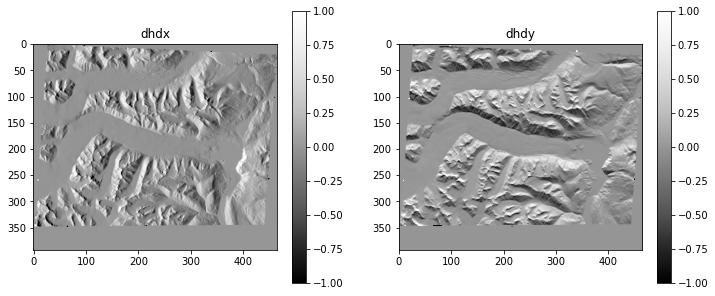

Save surface slope maps to /Volumes/SURGE_DISK/LO/


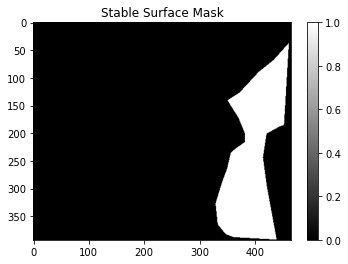

(197, 233)
Resampled to new dimensions: (197, 233)


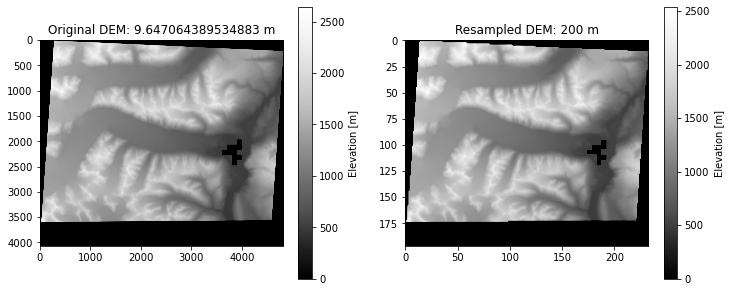

Save resampled DEM to /Volumes/SURGE_DISK/LO/LO_ArcticDEM_clipped_200m.tif


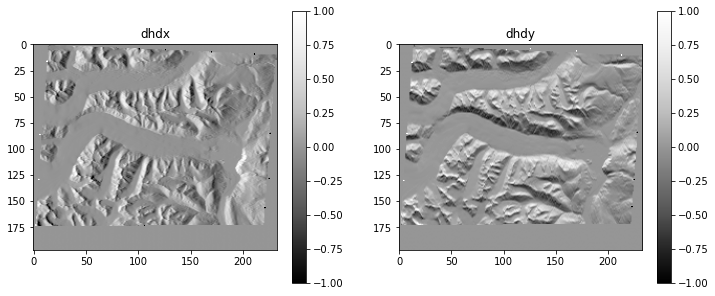

Save surface slope maps to /Volumes/SURGE_DISK/LO/


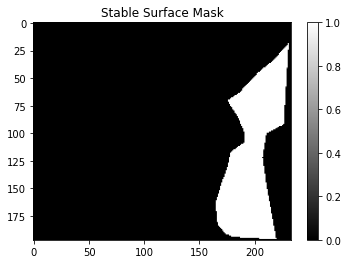

In [7]:
for chipsize in [100,200]:
    generate_geogrid_inputs(chipsize, dempath, demname, refvpath, vx_fname, vy_fname, sr_scaling)

## 2) Function to geogrid with resampled DEM and other inputs

In [21]:
def run_geogrid_inhouse(out_path, img_type, indir_m, indir_s, MINCHIPSIZE, NO_DATA_VAL, dem, # required inputs
                        dhdx, dhdy, vx, vy, srx, sry, csminx, csminy, csmaxx, csmaxy, ssm, # optional inputs
                       ):
    import rasterio as rio
    import os
    
    CHIPSIZE_M = MINCHIPSIZE # set minimum chip size equal
    ############ Clear all old geogrid files ##########################
    for file in os.listdir(out_path):
        if file.startswith('window') and file.endswith('.tif'):
            print('removed', file)
            os.remove(out_path+file)
    print('Old files cleared.'); print()

    dem_info = gdal.Info(dem, format='json') # grab info from DEM
    print('Obtained DEM info.'); print()
#     print(dem_info)
#     print(dem_info['geoTransform'][1])

    ############ Run geogrid optical ##########################
    if img_type == 'OPT': # Optical images
        print('Processing optical images with geogrid.'); print()
        obj = GeogridOptical() # initialize geogrid object

        ############ Coregister the optical data (from coregisterLoadMetadataOptical) #############
        x1a, y1a, xsize1, ysize1, x2a, y2a, xsize2, ysize2, trans = obj.coregister(indir_m, indir_s)
#         print(trans)

        # grab dates from file names
        im1_name = indir_m.split('/')[-1]; im2_name = indir_s.split('/')[-1]
        if 'LC' in im1_name and 'LC' in im2_name:
            ds1 = im1_name.split('_')[3]
            ds2 = im2_name.split('_')[3]
        elif 'S2' in im1_name and 'S2' in im2_name:
            ds1 = im1_name.split('_')[2]
            ds2 = im2_name.split('_')[2]
        elif 'PS' in im1_name and 'PS' in im2_name:
            ds1 = im1_name.split('_')[1]
            ds2 = im2_name.split('_')[1]
        else:
            raise Exception('Optical data NOT supported yet!') 
        print('Optical images coregistered.'); print()

        ########### Load geogrid inputs and run (from runGeogridOptical) ################

        # grab info from above
        obj.startingX = trans[0]; obj.startingY = trans[3]
        obj.XSize = trans[1]; obj.YSize = trans[5]
        d0 = datetime.date(int(ds1[0:4]),int(ds1[4:6]),int(ds1[6:8]))
        d1 = datetime.date(int(ds2[0:4]),int(ds2[4:6]),int(ds2[6:8]))
        date_dt_base = d1 - d0
        obj.repeatTime = date_dt_base.total_seconds()
        obj.numberOfLines = ysize1; obj.numberOfSamples = xsize1
        obj.gridSpacingX = dem_info['geoTransform'][1] # output grid spacing is the same as the DEM

        # customize no data value and minimimum chip size
        obj.nodata_out = NO_DATA_VAL
        obj.chipSizeX0 = MINCHIPSIZE

        # set raster paths and names
        obj.dat1name = indir_m # first image
        obj.demname = dem # DEM
        obj.dhdxname = dhdx; obj.dhdyname = dhdy # surface slope
        obj.vxname = vx; obj.vyname = vy # reference velocity
        obj.srxname = srx; obj.sryname = sry # search range limits
        obj.csminxname = csminx; obj.csminyname = csminy # min chip size
        obj.csmaxxname = csmaxx; obj.csmaxyname = csmaxy # max chip size
        obj.ssmname = ssm # stable surface mask
        obj.winlocname = "window_location.tif"
        obj.winoffname = "window_offset.tif"
        obj.winsrname = "window_search_range.tif"
        obj.wincsminname = "window_chip_size_min.tif"
        obj.wincsmaxname = "window_chip_size_max.tif"
        obj.winssmname = "window_stable_surface_mask.tif"
        obj.winro2vxname = "window_rdr_off2vel_x_vec.tif"
        obj.winro2vyname = "window_rdr_off2vel_y_vec.tif"

        obj.runGeogrid() # RUN GEOGRID
        print('Optical geogrid finished.'); print()

    ############ Move files produced to the out_path directory ##############
    for file in os.listdir(os.getcwd()):
        if file.startswith('window') and file.endswith('.tif'):
            shutil.move(os.getcwd()+'/'+file, out_path+file)
    print('Geogrid output files moved')

## 3) Function to run autoRIFT with new parameters

In [8]:
# AutoRIFT  
def run_autoRIFT_inhouse(indir_m, indir_s, out_path, img_type, mpflag, xGrid, yGrid, # required parameters
                         FILTER, WALLISFILTERWIDTH, SPARSE_SEARCH_SAMPLE_RATIO, OVERSAMPLE_RATIO, MINCHIPSIZE,
                         Dx0, Dy0, CSMINx0, SRx0, SRy0, CSMAXx0, CSMAXy0, SSM, # optional parameters
                         noDataMask, nodataval, geogrid_run_info):
    CHIPSIZE_M = MINCHIPSIZE # set minimum chip size equal
    
    # requires grid location from geogrid
    origSize = xGrid.shape # grab original size from xGrid
    
    if img_type == 'OPT': ############# OPTICAL SETTINGS ############################# 
        print('Processing optical images with autoRIFT.'); print()
        optflag = 1 # turn on optical flag
        # Coregister and read in the two images (from loadProductOptical())
        obj = GeogridOptical()
        x1a, y1a, xsize1, ysize1, x2a, y2a, xsize2, ysize2, trans = obj.coregister(indir_m, indir_s, 0)

        # read dates from filenames
        indir_m = indir_m.split('/')[-1]; indir_s = indir_s.split('/')[-1]
        if 'LC' in indir_m and 'LC' in indir_s:
            ds1 = indir_m.split('_')[3]; ds2 = indir_s.split('_')[3]
            sat = 'LS'
        elif 'S2' in indir_m and 'S2' in indir_s:
            ds1 = indir_m.split('_')[2]; ds2 = indir_s.split('_')[2]
            sat = 'S2'
        elif 'PS' in indir_m and 'PS' in indir_s:
            ds1 = indir_m.split('_')[1]
            ds2 = indir_s.split('_')[1]
            sat = 'PS'
        else:
            raise Exception('Optical data NOT supported yet!')
        
            
        print('DATES: ')
        print(ds1, ds2); print(sat)

        # read in the images
        DS1 = gdal.Open(indir_m); DS2 = gdal.Open(indir_s)
        I1 = DS1.ReadAsArray(xoff=x1a, yoff=y1a, xsize=xsize1, ysize=ysize1)
        I1 = I1.astype(np.float32)
        I2 = DS2.ReadAsArray(xoff=x2a, yoff=y2a, xsize=xsize2, ysize=ysize2)
        I2 = I2.astype(np.float32)
        DS1=None; DS2=None # clear DS1 and DS2

        # Initialize autoRIFT object (from runAutorift())
        obj = autoRIFT()
#         obj.configure()

    elif img_type == 'SAR': ############# SAR SETTINGS #############################  
        print('Processing SAR images with autoRIFT.'); print()
        optflag = 0 # turn off opt flag
        # Read in the two SAR images (from loadProduct())
        img1 = IML.mmapFromISCE(filename1, logging); I1 = IMG.bands[0]
        img2 = IML.mmapFromISCE(filename2, logging); I2 = IMG.bands[0]
        I1 = np.abs(I1); I2 = np.abs(I2) # SAR amplitude only
        
    else:
        print("Image type not recognized. Use either 'OPT' or 'SAR'.")
        
    ############# Initialize autoRIFT object (from runAutorift()) ##################
    obj = autoRIFT()
#     obj.configure()
    
    obj.MultiThread = mpflag # multiprocessing
    obj.I1 = I1; obj.I2 = I2 # assign the images
    obj.xGrid = xGrid; obj.yGrid = yGrid # assign the grid 

    # GENERATE NO DATA MASK
    # where offset searching will be skipped based on 
    # 1) imported nodata mask and/or 2) zero values in the image
    for ii in range(obj.xGrid.shape[0]):
        for jj in range(obj.xGrid.shape[1]):
            if (obj.yGrid[ii,jj] != nodata)&(obj.xGrid[ii,jj] != nodata):
                if (I1[obj.yGrid[ii,jj]-1,obj.xGrid[ii,jj]-1]==0)|(I2[obj.yGrid[ii,jj]-1,obj.xGrid[ii,jj]-1]==0):
                    noDataMask[ii,jj] = True
                    
    # SEARCH RANGE
    if SRx0 is None:
        # default is a zero array
#        ###########     uncomment to customize SearchLimit based on velocity distribution 
        if Dx0 is not None:
            obj.SearchLimitX = np.int32(4+(25-4)/(np.max(np.abs(Dx0[np.logical_not(noDataMask)]))-np.min(np.abs(Dx0[np.logical_not(noDataMask)])))*(np.abs(Dx0)-np.min(np.abs(Dx0[np.logical_not(noDataMask)]))))
        else:
            obj.SearchLimitX = 15
        obj.SearchLimitY = 15
#        ###########
        obj.SearchLimitX = obj.SearchLimitX * np.logical_not(noDataMask)
        obj.SearchLimitY = obj.SearchLimitY * np.logical_not(noDataMask)
    else:
        obj.SearchLimitX = SRx0
        obj.SearchLimitY = SRy0
       ############ add buffer to search range
        obj.SearchLimitX[obj.SearchLimitX!=0] = obj.SearchLimitX[obj.SearchLimitX!=0] + 2
        obj.SearchLimitY[obj.SearchLimitY!=0] = obj.SearchLimitY[obj.SearchLimitY!=0] + 2
    
    # CHIP SIZE
    if CSMINx0 is not None:
        obj.ChipSizeMaxX = CSMAXx0
        obj.ChipSizeMinX = CSMINx0
        
        gridspacingx = MINCHIPSIZE # use the grid spacing from above
        chipsizex0 = MINCHIPSIZE
        pixsizex = trans[1] # grab from coregister function
    
        obj.ChipSize0X = int(np.ceil(chipsizex0/pixsizex/4)*4)
        obj.GridSpacingX = int(obj.ChipSize0X*gridspacingx/chipsizex0)

        RATIO_Y2X = CSMINy0/CSMINx0
        obj.ScaleChipSizeY = np.median(RATIO_Y2X[(CSMINx0!=nodata)&(CSMINy0!=nodata)])
#         obj.ScaleChipSizeY = 1 # USE SCALE OF 1 for square pixels
    else:
        if ((optflag == 1)&(xGrid is not None)):
            obj.ChipSizeMaxX = 32 # pixels
            obj.ChipSizeMinX = 16 # pixels
            obj.ChipSize0X = 16 # pixels
    
    # DOWNSTREAM SEARCH OFFSET
    if Dx0 is not None:
        obj.Dx0 = Dx0
        obj.Dy0 = Dy0
    else:
        obj.Dx0 = obj.Dx0 * np.logical_not(noDataMask)
        obj.Dy0 = obj.Dy0 * np.logical_not(noDataMask)

    # REPLACE NO DATA VALUES WITH 0
    obj.xGrid[noDataMask] = 0
    obj.yGrid[noDataMask] = 0
    obj.Dx0[noDataMask] = 0
    obj.Dy0[noDataMask] = 0
    if SRx0 is not None:
        obj.SearchLimitX[noDataMask] = 0
        obj.SearchLimitY[noDataMask] = 0
    if CSMINx0 is not None:
        obj.ChipSizeMaxX[noDataMask] = 0
        obj.ChipSizeMinX[noDataMask] = 0
    
    # convert azimuth offset to vertical offset as used in autoRIFT convention for SAR images
    if optflag == 0:
        obj.Dy0 = -1 * obj.Dy0
        
    ############## AutoRIFT Pre-processing (from runAutorift()) ############################
    t1 = time.time()
    print("Pre-process Start!!!")
    
    # FILTERING:
    if FILTER == 'WAL': 
        obj.preprocess_filt_wal() # WALLIS FILTER
#         obj.zeroMask = 1 # removes edges
        obj.WallisFilterWidth = WALLISFILTERWIDTH # optional, default supposedly 21
    elif FILTER == 'HPS':
        obj.preprocess_filt_hps() # HIGH PASS FILTER
    elif FILTER == 'SOB':
        obj.preprocess_filt_sob() # SOBEL FILTER
    elif FILTER == 'LAP':
        obj.preprocess_filt_lap()
    elif FILTER == 'DB':
        obj.preprocess_db() # LOGARITHMIC OPERATOR (NO FILTER), FOR TOPOGRAPHY
    else:
        print(FILTER, 'not recognized. Using default high pass filter instead.')
        obj.preprocess_filt_hps() # HIGH PASS FILTER
        
    print("Pre-process Done!!!")
    print(time.time()-t1)
    
    # CONVERT TO UNIFORM DATA TYPE
    t1 = time.time()
#    obj.DataType = 0
    obj.uniform_data_type()
    print("Uniform Data Type Done!!!")
    print(time.time()-t1)
    
    # OTHER :
    obj.sparseSearchSampleRate = 1
#    obj.colfiltChunkSize = 4

    obj.OverSampleRatio = 64
    if CSMINx0 is not None:
        obj.OverSampleRatio = {obj.ChipSize0X:16,obj.ChipSize0X*2:32,obj.ChipSize0X*4:64,obj.ChipSize0X*8:64}
    
    ####################### Run AutoRIFT (from runAutorift())  ############################
    t1 = time.time()
    print("AutoRIFT Start!!!")
    obj.runAutorift()
    print("AutoRIFT Done!!!")
    print(time.time()-t1)
    
    kernel = np.ones((3,3),np.uint8)
    noDataMask = cv2.dilate(noDataMask.astype(np.uint8),kernel,iterations = 1)
    noDataMask = noDataMask.astype(np.bool)

    # AT THIS POINT, THESE VARIABLES WILL BE CREATED:
    # obj.Dx, obj.Dy, obj.InterpMask, obj.ChipSizeX, obj.GridSpacingX, 
    # obj.ScaleChipSizeY, obj.SearchLimitX, obj.SearchLimitY, obj.origSize, noDataMask
    
    # PLOT RESULTS
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
    im1 = ax1.imshow(obj.Dx); ax1.set_title('Dx'); fig.colorbar(im1, ax=ax1)
    im2 = ax2.imshow(obj.Dy); ax2.set_title('Dy'); fig.colorbar(im2, ax=ax2)
    im3 = ax3.imshow(np.sqrt((obj.Dx**2) + (obj.Dy**2))); ax3.set_title('D_total'); fig.colorbar(im3,ax=ax3)
    plt.suptitle(ds1+' to '+ds2)
    plt.show()

    ####################### Write outputs (from runAutorift())  ############################
    t1 = time.time()
    print("Write Outputs Start!!!")
          
    # Write text file with parameters
    f =  open(out_path+'parameters_'+ds1+'_'+ds2+'_'+str(CHIPSIZE_M)+'m_'+sat+'.txt', 'w')
    f.write('Geogrid/AutoRIFT parameters for offset_'+ds1+'_'+ds2+'_'+str(CHIPSIZE_M)+'m_'+sat+'.tif:')
    f.write('NO_DATA_VAL: '+str(NO_DATA_VAL))
    f.write('Min chip size: '+str(MINCHIPSIZE))
    f.write('DEM: '+dem)
    f.write('dhdx: '+dhdx); f.write('dhdy: '+dhdy)
    f.write('vx: '+vx); f.write('vy: '+vy)
    f.write('srx: '+srx); f.write('sry: '+sry)
    f.write('csminx: '+csminx); f.write('csminy: '+csminy)
    f.write('csmaxx: '+csmaxx); f.write('csmaxy: '+csmaxy)
    f.write('stable surface mask: '+ssm)
    f.write('FILTER: '+FILTER)
    f.write('WALLISFILTERWIDTH: '+str(WALLISFILTERWIDTH))
    f.write('Spare search sample rate: '+str(SPARSE_SEARCH_SAMPLE_RATE))
    f.write('Oversample ratio: '+str(OVERSAMPLE_RATIO))
    if offset2vx is not None and offset2vy is not None:
        f.write('Velocity.TIF file created.')
    else:
        f.write('Velocity.TIF not created.')
    f.close() # close the parameter text file
          
    # open the window_location.tif file to gdalinfo
    ds = gdal.Open(gp+'window_location.tif')
    tran = ds.GetGeoTransform()
    proj = ds.GetProjection()
    srs = ds.GetSpatialRef()
    
    # initialize arrays
    DX = np.zeros(origSize,dtype=np.float32) * np.nan; DY = np.zeros(origSize,dtype=np.float32) * np.nan
    INTERPMASK = np.zeros(origSize,dtype=np.float32); CHIPSIZEX = np.zeros(origSize,dtype=np.float32)
    SEARCHLIMITX = np.zeros(origSize,dtype=np.float32); SEARCHLIMITY = np.zeros(origSize,dtype=np.float32)
    
    # fill in arays
    Dx = obj.Dx; Dy = obj.Dy; InterpMask = obj.InterpMask; ChipSizeX = obj.ChipSizeX
    SearchLimitX = obj.SearchLimitX; SearchLimitY = obj.SearchLimitY
    DX[0:Dx.shape[0],0:Dx.shape[1]] = Dx;  DY[0:Dy.shape[0],0:Dy.shape[1]] = Dy
    INTERPMASK[0:InterpMask.shape[0],0:InterpMask.shape[1]] = InterpMask
    CHIPSIZEX[0:ChipSizeX.shape[0],0:ChipSizeX.shape[1]] = ChipSizeX
    SEARCHLIMITX[0:SearchLimitX.shape[0],0:SearchLimitX.shape[1]] = SearchLimitX
    SEARCHLIMITY[0:SearchLimitY.shape[0],0:SearchLimitY.shape[1]] = SearchLimitY
    
    # mask out no data
    DX[noDataMask] = np.nan; DY[noDataMask] = np.nan
    INTERPMASK[noDataMask] = 0; CHIPSIZEX[noDataMask] = 0
    SEARCHLIMITX[noDataMask] = 0; SEARCHLIMITY[noDataMask] = 0
    if SSM is not None:
        SSM[noDataMask] = False
    DX[SEARCHLIMITX == 0] = np.nan; DY[SEARCHLIMITX == 0] = np.nan
    INTERPMASK[SEARCHLIMITX == 0] = 0; CHIPSIZEX[SEARCHLIMITX == 0] = 0
    if SSM is not None:
        SSM[SEARCHLIMITX == 0] = False

    # SAVE TO OFFSET.MAT FILE
    sio.savemat('offset_'+ds1+'_'+ds2+'_'+str(CHIPSIZE_M)+'m_'+sat+'.mat', # offset mat filename
                {'Dx':DX,'Dy':DY,'InterpMask':INTERPMASK,'ChipSizeX':CHIPSIZEX})
    print('Offset.mat written.')
    
    # CREATE THE GEOTIFFS
    driver = gdal.GetDriverByName('GTiff')
    
    # OFFSET.TIF
    outRaster = driver.Create("offset_"+ds1+'_'+ds2+'_'+str(CHIPSIZE_M)+'m_'+sat+".tif", # offset filename
                              int(xGrid.shape[1]), int(xGrid.shape[0]), 5, gdal.GDT_Float32)
    outRaster.SetGeoTransform(tran); outRaster.SetProjection(proj) # projections
    outband = outRaster.GetRasterBand(1); outband.WriteArray(DX) # DX
    outband.FlushCache()
    outband = outRaster.GetRasterBand(2); outband.WriteArray(DY) # DY
    outband.FlushCache()
    outband = outRaster.GetRasterBand(3); outband.WriteArray(np.sqrt((DX**2) + (DY**2))) # DY
    outband.FlushCache()
    outband = outRaster.GetRasterBand(4); outband.WriteArray(INTERPMASK) # INTERPMASK
    outband.FlushCache()
    outband = outRaster.GetRasterBand(5); outband.WriteArray(CHIPSIZEX) # CHIPSIZE
    outband.FlushCache()
    del outRaster
    print('Offset.tif written.')
    
    # VELOCITY.TIF
    if offset2vx is not None and offset2vy is not None:
        ds = gdal.Open(offset2vx) #### VX
        band = ds.GetRasterBand(1); offset2vx_1 = band.ReadAsArray()
        band = ds.GetRasterBand(2); offset2vx_2 = band.ReadAsArray()
        if ds.RasterCount > 2:
                band = ds.GetRasterBand(3)
                offset2vr = band.ReadAsArray()
        else:
                offset2vr = None
        band=None; ds=None
        offset2vx_1[offset2vx_1 == nodata] = np.nan
        offset2vx_2[offset2vx_2 == nodata] = np.nan

        ds = gdal.Open(offset2vy) #### VY
        band = ds.GetRasterBand(1); offset2vy_1 = band.ReadAsArray()
        band = ds.GetRasterBand(2); offset2vy_2 = band.ReadAsArray()
        if ds.RasterCount > 2:
                band = ds.GetRasterBand(3)
                offset2va = band.ReadAsArray()
        else:
                offset2va = None
        band=None; ds=None
        offset2vy_1[offset2vy_1 == nodata] = np.nan; offset2vy_2[offset2vy_2 == nodata] = np.nan
        
        if offset2va is not None:
            offset2va[offset2va == nodata] = np.nan

        VX = offset2vx_1 * DX + offset2vx_2 * DY
        VY = offset2vy_1 * DX + offset2vy_2 * DY
        VX = VX.astype(np.float32); VY = VY.astype(np.float32)

        outRaster = driver.Create("velocity_"+ds1+'_'+ds2+'_'+str(CHIPSIZE_M)+'m_'+sat+".tif", # velocity filename
                                  int(xGrid.shape[1]), int(xGrid.shape[0]), 3, gdal.GDT_Float32)
        outRaster.SetGeoTransform(tran); outRaster.SetProjection(proj)
        outband = outRaster.GetRasterBand(1); outband.WriteArray(VX) # VX
        outband.FlushCache()
        outband = outRaster.GetRasterBand(2); outband.WriteArray(VY) # VY
        outband.FlushCache()
        outband = outRaster.GetRasterBand(3); outband.WriteArray(np.sqrt((VX**2) + (VY**2))) # V
        outband.FlushCache()
        del outRaster
        print('Velocity.tif written.')
    
    print("Write Outputs Done!!!")
    print(time.time()-t1)
    
    # Move files produced to the out_path directory
    for file in os.listdir(os.getcwd()):
        if 'offset' in file or ('velocity' in file and '.tif' in file):
            shutil.move(os.getcwd()+'/'+file, out_path+file)

# 4) Run geogrid and autoRIFT on all images in a folder

Adjusted to run on all image pairs that adhere to the date separation in days (dt) and start/end date set below, for all chipsizes in the chipsize list.

In [19]:
# s2path = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/sentinel2/' # input S2 images
# LS8path = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/LS8images/useable_images/' # input LS8 images
# PSpath = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/Planet_test/'
# S1path = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/sentinel1/'
# PSpath = '/Volumes/SGlacier/TG_20_21/'
# boxpath = '/Users/surging/Documents/TG/BoxTurner/BoxTurner_UTM_07.shp' # the shapefile for Turner
# autoriftpath = '/Users/surging/Documents/TG/autoRIFT/' # path to the autorift scripts
# vmap_path = '/Users/surging/Documents/TG/vmap_test/' # output velocity map folder
# basepath = '/Users/surging/Documents/TG/optical-offset-tracking/' # path where this script is located
LS8path = '/Volumes/LaCie/Variegated_LS_images/' # input LS8 images

######### Set minimum and maximum time separation and the platform (L8, S2, PS, S1) ###############
platform = 'L8'
startdate = '20120101' # inclusive start date
enddate = '20220101' # inclusive end date
min_dt = 5 # minimum time separation between images
max_dt = 60 # maximum time separation between images
###############################################################################################

chipsize_list = [100,200,300] # meters
out_path = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/output_AutoRIFT/' # output file path
NO_DATA_VAL = -32767 # no data value in the output products

In [10]:
# assign the folder path based on the platform
if platform == 'S2': # sentinel-2
    path = s2path
    ext = '_clipped.tif' # image filename extension
    img_type = 'OPT'
    date_split_idx = 2 # split filename by underscore, index corresponds to image date
elif platform == 'L8': # landsat 8
    path = LS8path
    ext = '.TIF'
    img_type = 'OPT'
    date_split_idx = 3
elif platform == 'PS': # PlanetScope
    path = PSpath
    ext = '_clipped.tif'  
    img_type = 'OPT'
    date_split_idx = 1
else:
    print('Platform', platform, 'not recognized. Options are "S2", "L8", and "PS"')

# record all possible images and their dates
dates = []; files = []  
for file in os.listdir(path):
    if file.endswith(ext):
        date = file.split('_')[date_split_idx] # grab the date from the filename
        dates.append(date); files.append(file) # store the date and filename
files_df = pd.DataFrame(list(zip(files,dates)),columns=['filename','date'])
files_df = files_df.sort_values(by='date',ignore_index=True) # sort the dataframe by ascending date
files_df

,filename,date
0,LC08_L1TP_061018_20130610_20200912_02_T1_B8_Bu...,20130610
1,LC08_L1TP_061018_20130610_20200912_02_T1_B8_Bu...,20130610
2,LC08_L1TP_061018_20130712_20200912_02_T1_B8_Bu...,20130712
3,LC08_L1TP_061018_20130712_20200912_02_T1_B8_Bu...,20130712
4,LC08_L1TP_062018_20131007_20200913_02_T1_B8_Bu...,20131007
...,...,...
161,LC08_L1TP_061018_20221025_20221107_02_T1_B8_Bu...,20221025
162,LC08_L1TP_062018_20221117_20221128_02_T2_B8_Bu...,20221117
163,LC08_L1TP_062018_20221117_20221128_02_T2_B8_Bu...,20221117
164,LC08_L1TP_062018_20221203_20221212_02_T1_B8_Bu...,20221203


In [11]:
# filter out those before and afte the input start and end date
files_df = files_df[(files_df.date >= startdate) & (files_df.date <= enddate)]
files_df = files_df.reset_index(drop=True) # reset index for searching
files_df

,filename,date
0,LC08_L1TP_061018_20130610_20200912_02_T1_B8_Bu...,20130610
1,LC08_L1TP_061018_20130610_20200912_02_T1_B8_Bu...,20130610
2,LC08_L1TP_061018_20130712_20200912_02_T1_B8_Bu...,20130712
3,LC08_L1TP_061018_20130712_20200912_02_T1_B8_Bu...,20130712
4,LC08_L1TP_062018_20131007_20200913_02_T1_B8_Bu...,20131007
...,...,...
141,LC08_L1TP_062018_20201010_20201016_02_T1_B8_Bu...,20201010
142,LC08_L1TP_061018_20201019_20201105_02_T1_B8_Bu...,20201019
143,LC08_L1TP_061018_20201019_20201105_02_T1_B8_Bu...,20201019
144,LC08_L1TP_061018_20201120_20210314_02_T1_B8_Bu...,20201120


In [12]:
# drop duplicate dates for S2, keep the original over the PS imitation
if platform == 'S2':
    unique_dates = list(set(files_df.date))
    for date in unique_dates:
        date_df = files_df[files_df.date == date]
        if len(date_df) > 1: # if there's a duplicate
            for idx, row in date_df.iterrows():
                if row.filename.startswith('S2P'):
                    files_df = files_df.drop(idx)
files_df

,filename,date
0,LC08_L1TP_061018_20130610_20200912_02_T1_B8_Bu...,20130610
1,LC08_L1TP_061018_20130610_20200912_02_T1_B8_Bu...,20130610
2,LC08_L1TP_061018_20130712_20200912_02_T1_B8_Bu...,20130712
3,LC08_L1TP_061018_20130712_20200912_02_T1_B8_Bu...,20130712
4,LC08_L1TP_062018_20131007_20200913_02_T1_B8_Bu...,20131007
...,...,...
141,LC08_L1TP_062018_20201010_20201016_02_T1_B8_Bu...,20201010
142,LC08_L1TP_061018_20201019_20201105_02_T1_B8_Bu...,20201019
143,LC08_L1TP_061018_20201019_20201105_02_T1_B8_Bu...,20201019
144,LC08_L1TP_061018_20201120_20210314_02_T1_B8_Bu...,20201120


## Once satisfied with the image list, adjust the code below to indicate the satellite platforms used (S2, L8, PS):

Image naming convention:

Sentinel-2 (S2) images contain the date as the third item split by underscores "_" and end in "_clipped.tif".

Landsat 8 (L8) images contain the date as the fourth item split by underscores "_" and end in "TIF".

PlanetScope (PS) images contain the date as the second item split by underscores "_" and end in "_clipped.tif".

#### If your image naming convention differs, adjust L6-28 in the cell below.

## Also set the optional inputs within the cell (L56-78)

In [ ]:
# try multiple chip sizes and sats
# for platform in ['S2','L8']:
for platform in ['L8']:
# for platform in [platforms]:
    # assign the folder path based on the platform
    if platform == 'S2': # sentinel-2
        path = s2path
        ext = '_clipped.tif' # image filename extension
        img_type = 'OPT'
        date_split_idx = 2 # split filename by underscore, index corresponds to image date
    elif platform == 'L8': # landsat 8
        path = LS8path
        ext = '.TIF'
        img_type = 'OPT'
        date_split_idx = 3
    elif platform == 'PS': # PlanetScope
        path = PSpath
        ext = '_clipped.tif'  
        img_type = 'OPT'
        date_split_idx = 1
    else:
        print('Platform', platform, 'not recognized. Options are "S2", "L8", and "PS"')

    # record all possible images and their dates
    dates = []; files = []  
    for file in os.listdir(path):
        if file.endswith(ext):
            date = file.split('_')[date_split_idx] # grab the date from the filename
            dates.append(date); files.append(file) # store the date and filename
    files_df = pd.DataFrame(list(zip(files,dates)),columns=['filename','date'])
    files_df = files_df.sort_values(by='date',ignore_index=True) # sort the dataframe by ascending date
    files_df = files_df[(files_df.date >= startdate) & (files_df.date <= enddate)]
    files_df = files_df.reset_index(drop=True) # reset index for searching
    print("Number of files found:",len(files_df))
    
    for min_chipsize in chipsize_list:
        # automatically set file names
        dhdx_outfile = demname[:-4]+'_'+str(CHIPSIZE_M)+'m_dhdx.tif' # generate new filename
        dhdy_outfile = demname[:-4]+'_'+str(CHIPSIZE_M)+'m_dhdy.tif' # generate new filename
        ssm_outfile = 'ssm_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
        vx_outfile = 'vx_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
        vy_outfile = 'vy_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
        srx_outfile = 'srx_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
        sry_outfile = 'sry_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
        csminx_fname = 'csminx_'+str(CHIPSIZE_M)+'m.tif'
        csminy_fname = 'csminy_'+str(CHIPSIZE_M)+'m.tif'
        csmaxx_fname = 'csmaxx_'+str(CHIPSIZE_M)+'m.tif'
        csmaxy_fname = 'csmaxy_'+str(CHIPSIZE_M)+'m.tif'
        
        MINCHIPSIZE = min_chipsize
        # generate geogrid inputs and grab outfilenames
        [dem_outfile, dhdx_outfile, dhdy_outfile, 
         vx_outfile, vy_outfile, srx_outfile, 
         sry_outfile, ssm_outfile] = generate_geogrid_inputs(min_chipsize, dempath, demname, 
                                                                         refvpath, vx_fname, vy_fname, 
                                                                         sr_scaling)
#         [dem_outfile, dhdx_outfile, dhdy_outfile] = generate_geogrid_inputs(min_chipsize, dempath, demname, 
#                                                                          refvpath, vx_fname, vy_fname, 
#                                                                          sr_scaling)
        #######################################################################
        # # CHOOSE OPTIONAL INPUTS: (set as '' to leave blank)
        # # 1) surface slope:
        #   dhdx = ''; dhdy = ''  
        dhdx = dempath+dhdx_outfile; dhdy = dempath+dhdy_outfile
        
        # # 2) reference velocity:
#         vx = ''; vy = ''    
        vx = refvpath+vx_fname; vy = refvpath+vy_fname
        
        # # 3) chip sizes:
        csminx = ''; csminy = ''
        csmaxx = ''; csmaxy = ''  
        #             csminx = refvpath+csminx_fname; csminy = refvpath+csminy_fname
        #             csmaxx = refvpath+csmaxx_fname; csmaxy = refvpath+csmaxy_fname
        
        # # 4) stable surface mask:
        ssm = ''
        #             ssm = refvpath+ssm_outfile # stable surface mask 
        
        # # 5) search range limit:
        srx = ''; sry = '' # for best results, never input search range limit
        #######################################################################
        
        for rownum in range(0,len(files_df)-1):
            if rownum == 0: # for the first row, idx1 = 0 and idx2 = 1
                idx1 = rownum
#             idx2 = idx1+1 # reset index 2 as the next item - SEQUENTIAL
            for idx2, row in files_df[idx1:].iterrows(): # for all subsequent idxs - ALL PAIRS

                if idx1 < len(files_df) and idx2 < len(files_df): # don't surpass the end of the data
                    # identify the successive image pairs:
                    m = files_df.loc[idx1,'filename']; s = files_df.loc[idx2, 'filename']

                    # grab the two dates and convert to datetime objects
                    d1s = m.split('_')[date_split_idx]; d2s = s.split('_')[date_split_idx]
                    if platform == 'S1': # S1 filenames need another split
                        d1s = d1s[:8]; d2s = d2s[:8]

                    # calculate time separation
                    d1 = datetime.datetime.strptime(d1s, '%Y%m%d'); d2 = datetime.datetime.strptime(d2s, '%Y%m%d')
                    dt = d2-d1; dt = int(dt.days)
                    

                    # run geogrid and autoRIFT
                    if m is not None and s is not None:
                        print(m,s)
                        indir_m = path+m; indir_s = path+s # path to the two images

                        dem = dempath+demname
                        dhdx = dempath+dhdx_outfile
                        dhdy = dempath+dhdy_outfile
                        ###################### RUN GEOGRID ################################
                        run_geogrid_inhouse(out_path, img_type, indir_m, indir_s, MINCHIPSIZE, NO_DATA_VAL, dem, # required inputs
                                            dhdx, dhdy, vx, vy, srx, sry, csminx, csminy, csmaxx, csmaxy, ssm, # optional inputs
                                            )

                        ##################### PREP AUTORIFT ##############################
                        gp = out_path # identify files produced from geogrid
                        # remove all empty grids
                        for grid in os.listdir(gp): 
                            if grid.startswith('window') and grid.endswith('.tif'):
                                reader = rio.open(gp+grid) # read dataset
                                data_found = False 
                                for band in range(1,reader.count+1):
                                    testband = reader.read(band) # read in the band
                                    if np.count_nonzero(testband[testband != NO_DATA_VAL]) > 0:
                                        data_found = True
                                if not data_found:
                                    print(grid, 'has no data. Removed.')
                                    os.remove(gp+grid)

                        # fill in AutoRIFT parameters using the files
                        mpflag = 0 # leave multiprocessing off

                        # GRID LOCATION (required) from window_location.tif
                        grid_location = rio.open(gp+'window_location.tif')
                        xGrid = grid_location.read(1) # 1st band in window location
                        yGrid = grid_location.read(2) # 2nd band in window location

                        # optional parameters (default None or zero until filled)
                        init_offset = None; search_range = None
                        chip_size_min = None; chip_size_max = None
                        offset2vx = None; offset2vy = None; stable_surface_mask = None
                        Dx0 = None; Dy0 = None; CSMINx0 = None
                        SRx0 = None; SRy0 = None;
                        CSMAXx0 = None; CSMAXy0 = None; SSM = None
                        noDataMask = np.zeros(xGrid.shape).astype(int)

                        if os.path.exists(gp+'window_offset.tif'): # Dx0 and Dy0 from window_offset.tif
                            init_offset = rio.open(gp+'window_offset.tif')
                            Dx0 = init_offset.read(1); Dy0 = init_offset.read(2)
                        if os.path.exists(gp+'window_search_range.tif'): # SRx0 and SRy0 from window_search_range.tif
                            search_range = rio.open(gp+'window_search_range.tif')
                            SRx0 = search_range.read(1); SRy0 = search_range.read(2)
                        if os.path.exists(gp+'window_chip_size_min.tif'): # CSMINx0 and CSMINy0 from window_chip_size_min.tif
                            chip_size_min = rio.open(gp+'window_chip_size_min.tif')
                            CSMINx0 = chip_size_min.read(1); CSMINy0 = chip_size_min.read(2)
                        if os.path.exists(gp+'window_chip_size_max.tif'): # CSMAXx0 and CSMAXy0 from window_chip_size_max.tif
                            chip_size_max = rio.open(gp+'window_chip_size_max.tif')
                            CSMAXx0 = chip_size_max.read(1); CSMAXy0 = chip_size_max.read(2)
                        if os.path.exists(gp+'window_rdr_off2vel_x_vec.tif'): # offset2vx from window_rdr_off2vel_x_vec.tif
                            offset2vx = gp+'window_rdr_off2vel_x_vec.tif' # path to be read in with GDAL
                        if os.path.exists(gp+'window_rdr_off2vel_y_vec.tif'): # offset2vy from window_rdr_off2vel_y_vec.tif
                            offset2vy = gp+'window_rdr_off2vel_y_vec.tif' 
                        if os.path.exists(gp+'window_stable_surface_mask.tif'): # noDataMask from window_stable_surface_mask.tif
                            stable_surface_mask = rio.open(gp+'window_stable_surface_mask.tif')
                            noDataMask = stable_surface_mask.read(1)

                        # other parameters
                        nodata = NO_DATA_VAL # use same as in previous steps
                        geogrid_run_info=None
                        print('AutoRIFT parameters loaded.')

                    ##################### RUN AUTORIFT ##############################
                    print(indir_m, indir_s)
                    # run autoRIFT with function
                    run_autoRIFT_inhouse(indir_m, indir_s, out_path, img_type, mpflag, xGrid, yGrid, # required parameters
                                             FILTER, WALLISFILTERWIDTH, SPARSE_SEARCH_SAMPLE_RATE, 
                                             OVERSAMPLE_RATIO, MINCHIPSIZE,
                                             Dx0, Dy0, CSMINx0, SRx0, SRy0, CSMAXx0, CSMAXy0, SSM, # optional parameters
                                         noDataMask, nodata, geogrid_run_info=None)
